In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from netcal.metrics import ECE

import random

from utils_notebook import get_logits_targets, modal_probs_decreasing, f_probs_ovr_poe_logits_weighted_generalized, get_scale_probs
from utils_conformal import conformalize_anytime_nn, conformalize_anytime_nn_raps

import seaborn as sns
import scipy

from matplotlib.gridspec import GridSpec

IMTA and DViT results below are copied from the following repos:
- IMTA: https://github.com/metodj/IMTA/tree/guarantees
- DViT: https://github.com/metodj/Dynamic-Vision-Transformer/tree/guarantees

In [2]:
import matplotlib 

text_width = 5.50107 # in  --> Confirmed with template explanation
dpi = 300

fs_m1 = 10  # for figure ticks
fs = 12  # for regular figure text
fs_p1 = 14 #  figure titles

matplotlib.rc('font', size=fs)          # controls default text sizes
matplotlib.rc('axes', titlesize=fs)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=fs)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=fs_m1)    # legend fontsize
matplotlib.rc('figure', titlesize=fs_p1)  # fontsize of the figure title


matplotlib.rc('font', **{'family':'serif', 'serif': ['Palatino']})
matplotlib.rc('text', usetex=True)
# matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

# Figure 1

In [6]:
MODEL_FOLDER = 'models'
LIKELIHOOD = 'softmax'
EPOCH = 299

logits, targets, ARGS = get_logits_targets('cifar100', MODEL_FOLDER, LIKELIHOOD, EPOCH)

L = len(logits)
N = len(targets)

building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

In [7]:
probs = torch.softmax(logits, dim=2)
preds = {i: torch.argmax(probs, dim=2)[i, :] for i in range(L)}
acc = [(targets == preds[i]).sum() / len(targets) for i in range(L)]
msp = {i: torch.max(probs, dim=2).values[i, :] for i in range(L)}

In [42]:
# random.seed(0)

# for _ in range(5):
#     samples = random.sample(range(10000), 10)
#     print(samples)
#     for i in samples:
#         # probs_i = probs[:, i, preds[L - 1][i]].cpu()
#         probs_i = probs[:, i, targets[i]].cpu()
#         plt.plot(list(range(1, len(probs_i) + 1)), probs_i, label=f'{i}')
#     plt.show()

In [6]:
# # # ground-truth probs
# for i in [1528, 6534, 18, 8086, 5458, 3996, 5328, 1031, 3130, 9298]:
#     probs_i = probs[:, i, targets[i]].cpu()
#     plt.plot(list(range(1, len(probs_i) + 1)), probs_i, label=f'{i}')
#     plt.title(f'{i}')
#     plt.show()

In [41]:
# # modal probs
# for i in [6311, 6890, 663, 4242, 8376, 7961, 6634, 4969, 7808, 5866]:
#     probs_i = probs[:, i, preds[L - 1][i]].cpu()
#     # probs_i = probs[:, i, targets[i]].cpu()
#     plt.plot(list(range(1, len(probs_i) + 1)), probs_i, label=f'{i}')
#     plt.title(f'{i}')
#     plt.show()

{0.01: 67.36999999999999, 0.1: 49.78, 0.2: 41.67, 0.5: 23.150000000000002}


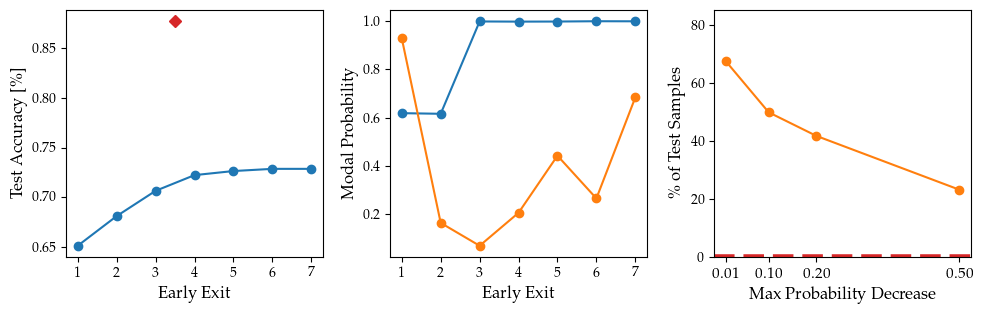

In [11]:
# FONT_SIZE = 12
# plt.rcParams.update({'font.size': FONT_SIZE})

PLOT_TYPE = 'Modal Probability'
# PLOT_TYPE = 'Ground-Truth Probability'

fig, ax = plt.subplots(1, 3, figsize=(10, 3.3))
early_exits = [i + 1 for i in range(L)]

ax[0].plot(early_exits, acc, label='NN', marker='o')
ax[0].plot([3.5], [0.877], marker='D', markersize=6, color='tab:red')
ax[0].set_xlabel('Early Exit')
ax[0].set_ylabel('Test Accuracy [\%]')
ax[0].set_xticks(early_exits)

ax[1].set_xlabel('Early Exit')
ax[1].set_ylabel(PLOT_TYPE)
if PLOT_TYPE == 'Modal Probability':
    for i in [6311, 8376]:
        probs_i = probs[:, i, preds[L - 1][i]].cpu()
        ax[1].plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o')
elif PLOT_TYPE == 'Ground-Truth Probability':
    for i in [6311, 6534]:
        probs_i = probs[:, i, targets[i]].cpu()
        ax[1].plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o')
ax[1].set_xticks(early_exits)

THRESHOLDS = [-0.01, -0.1, -0.2, -0.5]
ax[2].set_xlabel('Max Probability Decrease')
ax[2].set_ylabel('\% of Test Samples')
if PLOT_TYPE == 'Modal Probability':
    probs_decrase = modal_probs_decreasing(preds, probs, L, N=N, diffs_type="all", thresholds=THRESHOLDS)
elif PLOT_TYPE == 'Ground-Truth Probability':
    probs_decrase = modal_probs_decreasing(targets, probs, layer=None, N=N, diffs_type="all", thresholds=THRESHOLDS)
print(probs_decrase)
ax[2].plot(probs_decrase.keys(), probs_decrase.values(), marker='o',  color='tab:orange')
# ax[2].set_xticks(list(probs_decrase.keys()), [int(i * 100) for i in probs_decrase.keys()])
ax[2].set_xticks(list(probs_decrase.keys()))
ax[2].tick_params(labelsize=11, axis='x')
ax[2].set_ylim([0., 85.])
# ax[2].set_ylabel('\% of Test Samples')
ax[2].axhline(y=0, color="tab:red", linewidth=4, linestyle='--')

plt.tight_layout()
# plt.savefig(f'figures/figure_1_{PLOT_TYPE}.pdf', dpi=1200)
plt.show()

TODO: add plot for maximum-softmax-probability decreases

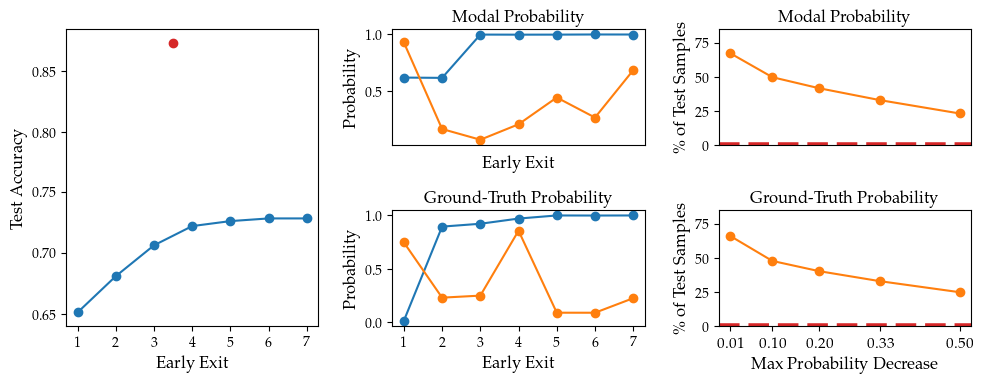

In [8]:
early_exits = [i + 1 for i in range(L)]


def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
        ax.tick_params(labelbottom=False, labelleft=False)

fig = plt.figure(constrained_layout=True, figsize=(10, 4))

gs = GridSpec(2, 3, figure=fig)
ax1 = fig.add_subplot(gs[:2, 0])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[0, 2])
ax5 = fig.add_subplot(gs[1, 2])

# fig.suptitle("GridSpec")
# format_axes(fig)

ax1.plot(early_exits, acc, label='NN', marker='o')
ax1.set_xlabel('Early Exit')
ax1.set_ylabel('Test Accuracy')
ax1.plot([3.5], [0.873], marker='o', markersize=6, color='tab:red')
ax1.set_xticks(early_exits)

ax2.set_xlabel('Early Exit')
ax2.set_ylabel('Probability')
ax2.set_title('Modal Probability')
ax2.set_xticks([])
for i in [6311, 8376]:
    probs_i = probs[:, i, preds[L - 1][i]].cpu()
    ax2.plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o')


ax3.set_xlabel('Early Exit')
ax3.set_ylabel('Probability')
ax3.set_title('Ground-Truth Probability')
ax3.set_xticks(early_exits)
for i in [4969, 6534]:
    probs_i = probs[:, i, targets[i]].cpu()
    ax3.plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o')


THRESHOLDS = [-0.01, -0.1, -0.2, -0.33, -0.5]
# ax4.set_xlabel('Max Probability Decrease')
# ax4.set_ylabel('\% of Test Samples')
probs_decrase = modal_probs_decreasing(preds, probs, L, N=N, diffs_type="all", thresholds=THRESHOLDS)

ax4.plot(probs_decrase.keys(), probs_decrase.values(), marker='o',  color='tab:orange')
# ax[2].set_xticks(list(probs_decrase.keys()), [int(i * 100) for i in probs_decrase.keys()])
ax4.set_xticks([])
ax4.tick_params(labelsize=11, axis='x')
ax4.set_ylim([0., 85.])
ax4.set_ylabel('\% of Test Samples')
ax4.axhline(y=0, color="tab:red", linewidth=4, linestyle='--')
ax4.set_title('Modal Probability')

ax5.set_xlabel('Max Probability Decrease')
ax5.set_ylabel('\% of Test Samples')
probs_decrase = modal_probs_decreasing(targets, probs, layer=None, N=N, diffs_type="all", thresholds=THRESHOLDS)

ax5.plot(probs_decrase.keys(), probs_decrase.values(), marker='o',  color='tab:orange')
# ax[2].set_xticks(list(probs_decrase.keys()), [int(i * 100) for i in probs_decrase.keys()])
ax5.set_xticks(list(probs_decrase.keys()))
ax5.tick_params(labelsize=11, axis='x')
ax5.set_ylim([0., 85.])
# ax[2].set_ylabel('\% of Test Samples')
ax5.axhline(y=0, color="tab:red", linewidth=4, linestyle='--')
ax5.set_title('Ground-Truth Probability')



# elif PLOT_TYPE == 'Ground-Truth Probability':
#     
# print(probs_decrase)

plt.tight_layout()
plt.savefig(f'figures/figure_1_alt.pdf', dpi=1200)
plt.show()

# Figure 2

In [22]:
CIFAR_10_DICT = {"MSDNet": [0.833, 0.8575, 0.8733, 0.8768, 0.8779, 0.8687, 0.8692],
                 "MSDNet PoE-OVR": [0.833, 0.8627, 0.8803, 0.8857, 0.8881, 0.884, 0.8838],
                 "IMTA": [0.89, 0.9064, 0.9181, 0.9201, 0.9237, 0.9258, 0.9259],
                 "IMTA PoE-OVR": [0.89, 0.9033, 0.9131, 0.9186, 0.9215, 0.9227, 0.9252],
                 "DViT": [0.9636, 0.9744, 0.9809],
                 "DViT PoE-OVR": [0.9636, 0.9742, 0.9786],
                }

CIFAR_100_DICT = {"MSDNet": [0.65130, 0.68110, 0.7064, 0.72229, 0.7264, 0.7286, 0.7286000], 
                  "MSDNet PoE-OVR": [0.6513, 0.7027, 0.7343, 0.748, 0.7552, 0.7567, 0.7559], 
                  "IMTA": [0.6222, 0.6685, 0.6966, 0.7143, 0.7189, 0.7216, 0.7226], 
                  "IMTA PoE-OVR": [0.6222, 0.6665, 0.6958, 0.7148, 0.7255, 0.7316, 0.7331],
                  "DViT": [0.8374, 0.8579, 0.8716],
                  "DViT PoE-OVR": [0.8374, 0.8642, 0.8756],
                }


IMAGE_NET_DICT = {"MSDNet": [0.5663, 0.6514, 0.6842, 0.6977, 0.7134],
                  "MSDNet PoE-OVR": [0.5663, 0.6508, 0.6867, 0.7022, 0.7138],
                  "IMTA": [0.5716, 0.6585, 0.6998, 0.7186, 0.7275],
                  "IMTA PoE-OVR": [0.5716, 0.6541, 0.6931, 0.7142, 0.7304],
                  "DViT": [0.7267, 0.7899, 0.818],
                  "DViT PoE-OVR": [0.7267, 0.7847, 0.816]}


In [23]:
COLOR_DICT = {"MSDNet": "tab:blue", "IMTA": "tab:green", "DViT": "tab:orange"}

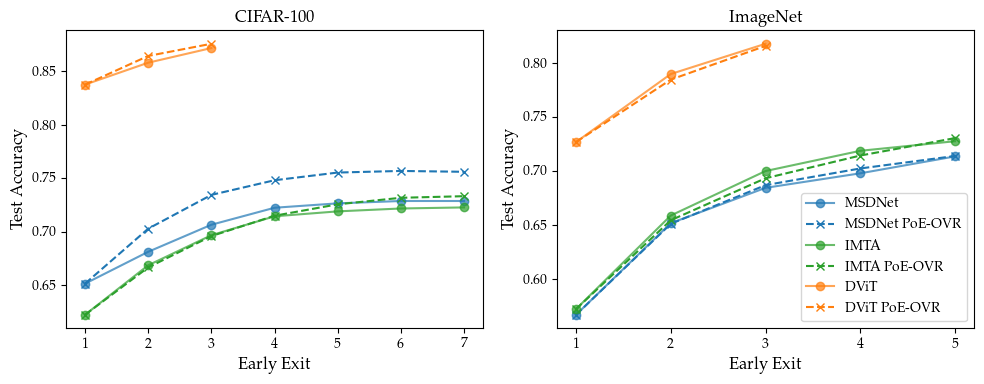

In [24]:
# sns.set_theme()
# FONT_SIZE = 11
# plt.rcParams.update({'font.size': FONT_SIZE})

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(list(range(1, len(CIFAR_100_DICT["MSDNet"]) + 1)), CIFAR_100_DICT["MSDNet"], label='MSDNet', marker='o', color=COLOR_DICT["MSDNet"], alpha=0.7)
ax[0].plot(list(range(1, len(CIFAR_100_DICT["MSDNet PoE-OVR"]) + 1)), CIFAR_100_DICT["MSDNet PoE-OVR"], label='MSDNet PoE-OVR', marker='x', color=COLOR_DICT["MSDNet"], linestyle='--')
ax[0].plot(list(range(1, len(CIFAR_100_DICT["IMTA"]) + 1)), CIFAR_100_DICT["IMTA"], label='IMTA', marker='o', color=COLOR_DICT["IMTA"], alpha=0.7)
ax[0].plot(list(range(1, len(CIFAR_100_DICT["IMTA PoE-OVR"]) + 1)), CIFAR_100_DICT["IMTA PoE-OVR"], label='IMTA PoE-OVR', marker='x', color=COLOR_DICT["IMTA"], linestyle='--')
ax[0].plot(list(range(1, len(CIFAR_100_DICT["DViT"]) + 1)), CIFAR_100_DICT["DViT"], label='DViT', marker='o', color=COLOR_DICT["DViT"], alpha=0.7)
ax[0].plot(list(range(1, len(CIFAR_100_DICT["DViT PoE-OVR"]) + 1)), CIFAR_100_DICT["DViT PoE-OVR"], label='DViT PoE-OVR', marker='x', color=COLOR_DICT["DViT"], linestyle='--')
ax[0].set_xlabel('Early Exit')
ax[0].set_ylabel('Test Accuracy')
ax[0].set_title('CIFAR-100')
ax[0].set_xticks([x for x in range(1, 8)])
# ax[0].legend()



ax[1].plot(list(range(1, len(IMAGE_NET_DICT["MSDNet"]) + 1)), IMAGE_NET_DICT["MSDNet"], label='MSDNet', marker='o', color=COLOR_DICT["MSDNet"], alpha=0.7)
ax[1].plot(list(range(1, len(IMAGE_NET_DICT["MSDNet PoE-OVR"]) + 1)), IMAGE_NET_DICT["MSDNet PoE-OVR"], label='MSDNet PoE-OVR', marker='x', color=COLOR_DICT["MSDNet"], linestyle='--')
ax[1].plot(list(range(1, len(IMAGE_NET_DICT["IMTA"]) + 1)), IMAGE_NET_DICT["IMTA"], label='IMTA', marker='o', color=COLOR_DICT["IMTA"], alpha=0.7)
ax[1].plot(list(range(1, len(IMAGE_NET_DICT["IMTA PoE-OVR"]) + 1)), IMAGE_NET_DICT["IMTA PoE-OVR"], label='IMTA PoE-OVR', marker='x', color=COLOR_DICT["IMTA"], linestyle='--')
ax[1].plot(list(range(1, len(IMAGE_NET_DICT["DViT"]) + 1)), IMAGE_NET_DICT["DViT"], label='DViT', marker='o', color=COLOR_DICT["DViT"], alpha=0.7)
ax[1].plot(list(range(1, len(IMAGE_NET_DICT["DViT PoE-OVR"]) + 1)), IMAGE_NET_DICT["DViT PoE-OVR"], label='DViT PoE-OVR', marker='x', color=COLOR_DICT["DViT"], linestyle='--')
ax[1].set_xlabel('Early Exit')
ax[1].set_ylabel('Test Accuracy')
ax[1].set_title('ImageNet')
# ax[1].legend(fontsize=11)
ax[1].set_xticks([x for x in range(1, 6)])
ax[1].legend()


plt.tight_layout()
plt.savefig(f'figures/figure_2.pdf')
plt.show()

# Tables 1 & 2

In [4]:
THRESHOLDS = [-x for x in [-0.0001, -0.01, -0.05, -0.1, -0.2, -0.25, -0.33, -0.5]]

CIFAR_10_DICT = {"MSDNet": [70.47, 45.98, 34.5, 28.6, 21.15, 18.16, 14.02, 7.43],
                "MSDNet PoE-OVR": [5.47, 3.73, 0.98, 0.25, 0.05, 0.03, 0.01, 0.01],
                "IMTA": [47.04, 19.98, 12.82, 9.83, 5.62, 4.55, 3.0, 1.0],
                "IMTA PoE-OVR": [1.99, 1.24, 0.27, 0.01, 0.0, 0.0, 0.0, 0.0],
                "DViT": [37.6, 4.63, 2.65, 1.83, 1.04, 0.79, 0.54, 0.13],
                "DViT PoE-OVR": [0.43, 0.27, 0.06, 0.03, 0.0, 0.0, 0.0, 0.0],
                }
CIFAR_100_DICT = {"MSDNet": [86.55, 67.37, 56.28, 49.78, 41.67, 38.21, 32.93, 23.15], 
                  "MSDNet PoE-OVR": [0.36, 0.12, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 
                  "IMTA": [74.75, 53.61, 41.85, 35.13, 25.96, 22.8, 17.69, 9.39], 
                  "IMTA PoE-OVR": [0.3, 0.15, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0],
                  "DViT": [67.44, 32.98, 20.94, 15.2, 8.62, 6.71, 4.19, 1.29],
                  "DViT PoE-OVR": [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                }


IMAGE_NET_DICT = {"MSDNet": [84.326, 69.972, 51.72, 38.066, 20.518, 14.666, 8.336, 2.024],
                  "MSDNet PoE-OVR": [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                  "IMTA": [79.162, 61.17, 42.818, 30.452, 15.556, 10.884, 5.71, 1.184],
                  "IMTA PoE-OVR": [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                  "DViT": [59.57, 51.09, 25.696, 12.104, 4.384, 2.722, 1.314, 0.208],
                  "DViT PoE-OVR": [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


SELECTED_THRESHOLDS = [0.01, 0.1, 0.25]

In [5]:
cifar_10_guarantees_df = pd.DataFrame(CIFAR_10_DICT, index=THRESHOLDS).T[SELECTED_THRESHOLDS]
cifar_100_guarantees_df = pd.DataFrame(CIFAR_100_DICT, index=THRESHOLDS).T[SELECTED_THRESHOLDS]
image_net_guarantees_df = pd.DataFrame(IMAGE_NET_DICT, index=THRESHOLDS).T[SELECTED_THRESHOLDS]

In [6]:
cifar_10_guarantees_df

,0.01,0.10,0.25
MSDNet,45.98,28.60,18.16
MSDNet PoE-OVR,3.73,0.25,0.03
IMTA,19.98,9.83,4.55
IMTA PoE-OVR,1.24,0.01,0.00
DViT,4.63,1.83,0.79
DViT PoE-OVR,0.27,0.03,0.00


In [7]:
for row in cifar_10_guarantees_df.iterrows():
    print(row[0])
    print(' & '.join([str(x) for x in row[1].values]))

MSDNet
45.98 & 28.6 & 18.16
MSDNet PoE-OVR
3.73 & 0.25 & 0.03
IMTA
19.98 & 9.83 & 4.55
IMTA PoE-OVR
1.24 & 0.01 & 0.0
DViT
4.63 & 1.83 & 0.79
DViT PoE-OVR
0.27 & 0.03 & 0.0


In [8]:
cifar_100_guarantees_df

,0.01,0.10,0.25
MSDNet,67.37,49.78,38.21
MSDNet PoE-OVR,0.12,0.00,0.00
IMTA,53.61,35.13,22.80
IMTA PoE-OVR,0.15,0.00,0.00
DViT,32.98,15.20,6.71
DViT PoE-OVR,0.00,0.00,0.00


In [9]:
for row in cifar_100_guarantees_df.iterrows():
    print(row[0])
    print(' & '.join([str(x) for x in row[1].values]))

MSDNet
67.37 & 49.78 & 38.21
MSDNet PoE-OVR
0.12 & 0.0 & 0.0
IMTA
53.61 & 35.13 & 22.8
IMTA PoE-OVR
0.15 & 0.0 & 0.0
DViT
32.98 & 15.2 & 6.71
DViT PoE-OVR
0.0 & 0.0 & 0.0


In [10]:
image_net_guarantees_df

,0.01,0.10,0.25
MSDNet,69.972,38.066,14.666
MSDNet PoE-OVR,0.000,0.000,0.000
IMTA,61.170,30.452,10.884
IMTA PoE-OVR,0.000,0.000,0.000
DViT,51.090,12.104,2.722
DViT PoE-OVR,0.000,0.000,0.000


In [11]:
for row in image_net_guarantees_df.iterrows():
    print(row[0])
    print(' & '.join([str(x) for x in row[1].values]))

MSDNet
69.972 & 38.066 & 14.666
MSDNet PoE-OVR
0.0 & 0.0 & 0.0
IMTA
61.17 & 30.452 & 10.884
IMTA PoE-OVR
0.0 & 0.0 & 0.0
DViT
51.09 & 12.104 & 2.722
DViT PoE-OVR
0.0 & 0.0 & 0.0


# Figure 3

In [25]:
MODEL_FOLDER = 'models'
LIKELIHOOD = 'softmax'
EPOCH = 299

logits, targets, ARGS = get_logits_targets('cifar100', MODEL_FOLDER, LIKELIHOOD, EPOCH)

L = len(logits)
N = len(targets)

building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

In [26]:
probs = torch.softmax(logits, dim=2)
preds = {i: torch.argmax(probs, dim=2)[i, :] for i in range(L)}
acc = [(targets == preds[i]).sum() / len(targets) for i in range(L)]
msp = {i: torch.max(probs, dim=2).values[i, :] for i in range(L)}

In [27]:
T = 1.
probs_poe_ovr_break_ties_generalized = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(logits, weights=(np.arange(1, L + 1, 1, dtype=float) / L) * T))
preds_poe_ovr_break_ties_generalized = {i: torch.argmax(probs_poe_ovr_break_ties_generalized, dim=2)[i, :] for i in range(L)}
acc_poe_ovr_break_ties_generalized = [(targets == preds_poe_ovr_break_ties_generalized[i]).sum() / len(targets) for i in range(L)]

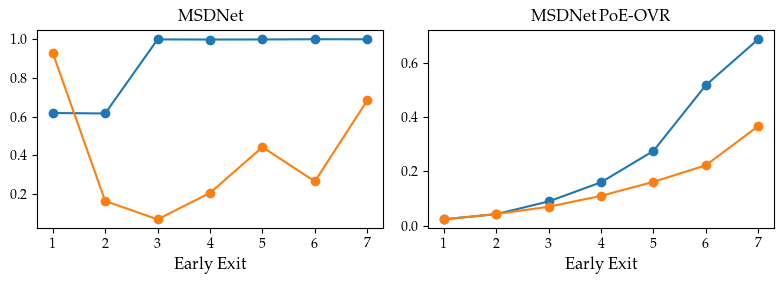

In [28]:
# FONT_SIZE = 12
# plt.rcParams.update({'font.size': FONT_SIZE})

PLOT_TYPE = 'Modal Probability'
# PLOT_TYPE = 'Ground-Truth Probability'

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
early_exits = [i + 1 for i in range(L)]

ax[0].set_xlabel('Early Exit')
# ax[0].set_ylabel(PLOT_TYPE)
if PLOT_TYPE == 'Modal Probability':
    for i, color in zip([6311, 8376], ['tab:blue', 'tab:orange']):
        probs_i = probs[:, i, preds[L - 1][i]].cpu()
        ax[0].plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o', color=color)
elif PLOT_TYPE == 'Ground-Truth Probability':
    for i in [6311, 6534]:
        probs_i = probs[:, i, targets[i]].cpu()
        ax[0].plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o')
ax[0].set_xticks(early_exits)
ax[0].set_title('MSDNet')


ax[1].set_xlabel('Early Exit')
# ax[1].set_ylabel(PLOT_TYPE)
if PLOT_TYPE == 'Modal Probability':
    for i, color in zip([6311, 8376], ['tab:blue', 'tab:orange']):
        probs_i = probs_poe_ovr_break_ties_generalized[:, i, preds_poe_ovr_break_ties_generalized[L - 1][i]].cpu()
        ax[1].plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o', color=color)
elif PLOT_TYPE == 'Ground-Truth Probability':
    for i in [6311, 6534]:
        probs_i = probs[:, i, targets[i]].cpu()
        ax[1].plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o')
ax[1].set_xticks(early_exits)
ax[1].set_title('MSDNet PoE-OVR')

plt.tight_layout()
plt.savefig(f'figures/figure_3_{PLOT_TYPE}.pdf', dpi=1200)
plt.show()

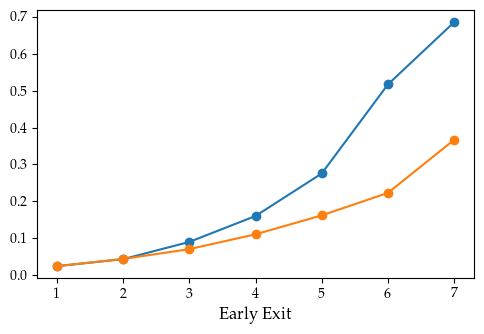

In [33]:
# FONT_SIZE = 12
# plt.rcParams.update({'font.size': FONT_SIZE})

PLOT_TYPE = 'Modal Probability'
# PLOT_TYPE = 'Ground-Truth Probability'

fig, ax = plt.subplots(1, 1, figsize=(5, 3.5))
early_exits = [i + 1 for i in range(L)]

plt.xlabel('Early Exit')
# ax[0].set_ylabel(PLOT_TYPE)
if PLOT_TYPE == 'Modal Probability':
    for i, color in zip([6311, 8376], ['tab:blue', 'tab:orange']):
        # probs_i = probs[:, i, preds[L - 1][i]].cpu()
        # plt.plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o', color=color)
        probs_i = probs_poe_ovr_break_ties_generalized[:, i, preds_poe_ovr_break_ties_generalized[L - 1][i]].cpu()
        plt.plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o', color=color)
elif PLOT_TYPE == 'Ground-Truth Probability':
    for i in [6311, 6534]:
        probs_i = probs[:, i, targets[i]].cpu()
        plt.plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o')
        probs_i = probs[:, i, targets[i]].cpu()
        plt.plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o')


plt.tight_layout()
plt.savefig(f'figures/figure_3_{PLOT_TYPE}_half.pdf', dpi=1200)
plt.show()

# Figure 4

In [3]:
MODEL_FOLDER = 'models'
LIKELIHOOD = 'softmax'
EPOCH = 299

logits, targets, ARGS = get_logits_targets('cifar100', MODEL_FOLDER, LIKELIHOOD, EPOCH)

L = len(logits)
N = len(targets)

building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

In [4]:
probs = torch.softmax(logits, dim=2)
preds = {i: torch.argmax(probs, dim=2)[i, :] for i in range(L)}
acc = [(targets == preds[i]).sum() / len(targets) for i in range(L)]
msp = {i: torch.max(probs, dim=2).values[i, :] for i in range(L)}

In [5]:
T = 1.
probs_poe_ovr_break_ties_generalized = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(logits, weights=(np.arange(1, L + 1, 1, dtype=float) / L) * T))
preds_poe_ovr_break_ties_generalized = {i: torch.argmax(probs_poe_ovr_break_ties_generalized, dim=2)[i, :] for i in range(L)}
acc_poe_ovr_break_ties_generalized = [(targets == preds_poe_ovr_break_ties_generalized[i]).sum() / len(targets) for i in range(L)]

In [6]:
scaled_dict = get_scale_probs(['PoE-OVR (tempered)'], [probs_poe_ovr_break_ties_generalized], [2.], targets, C=ARGS.num_classes, L=L)
probs_poe_ovr_break_ties_generalized_tempered = scaled_dict['PoE-OVR (tempered)'][2.0][0]

In [7]:
logits_poe = logits.cumsum(dim=0) / torch.tensor([float(x) for x in range(1, L + 1)])[:, None, None]
probs_poe = torch.softmax(logits_poe, dim=2)
preds_poe = {i: torch.argmax(probs_poe, dim=2)[i, :] for i in range(L)}
acc_poe = [(targets == preds_poe[i]).sum() / len(targets) for i in range(L)]

In [8]:
random.seed(10)
CALIB_SIZE = 0.2
ALPHA = 0.05
calib_ids = random.sample(range(N), int(CALIB_SIZE * N))
valid_ids = list(set(range(N)) - set(calib_ids))

# sizes_conf_sets,_ = conformalize_anytime_nn(probs.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L, conf_type='smx')
# sizes_conf_sets_poe,_ = conformalize_anytime_nn(probs_poe.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L, conf_type='smx')
# sizes_conf_sets_poe_ovr_break_ties_generalized, _ = conformalize_anytime_nn(probs_poe_ovr_break_ties_generalized.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L, conf_type='smx')
# sizes_conf_sets_poe_ovr_break_ties_generalized_tempered, _ = conformalize_anytime_nn(probs_poe_ovr_break_ties_generalized_tempered.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L, conf_type='smx')
sizes_conf_sets,_ = conformalize_anytime_nn_raps(probs.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L)
sizes_conf_sets_poe,_ = conformalize_anytime_nn_raps(probs_poe.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L)
sizes_conf_sets_poe_ovr_break_ties_generalized, _ = conformalize_anytime_nn_raps(probs_poe_ovr_break_ties_generalized.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L)
sizes_conf_sets_poe_ovr_break_ties_generalized_tempered, _ = conformalize_anytime_nn_raps(probs_poe_ovr_break_ties_generalized_tempered.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L)

1 1.0324606087471089
2 1.0220539274040485
3 1.0123616281770005
4 1.0068026686009128
5 1.0143509092629124
6 1.0157977970536824
7 1.0214844099900846
1 1.0340605317587253
2 0.9984795648122639
3 0.999057315222509
4 0.9989798294401248
5 0.9991445485715765
6 0.9988271512074601
7 0.9990138468815922
1 0.292660760541366
2 0.2816090956208361
3 0.37879942755717205
4 0.4892056975629171
5 0.6476367553918494
6 0.7623727736419716
7 0.895691289448709
1 0.32353862032158476
2 0.3743416227960145
3 0.5535346091904078
4 0.7311665678785775
5 0.8842605306204018
6 0.9631097532499084
7 0.993932823476801


In [9]:
entropy_baseline = scipy.stats.entropy(probs.numpy(), axis=2)
entropy_poe = scipy.stats.entropy(probs_poe.numpy(), axis=2)
entropy_poe_ovr_break_ties_generalized = scipy.stats.entropy(probs_poe_ovr_break_ties_generalized.numpy(), axis=2)
entropy_poe_ovr_break_ties_generalized_tempered = scipy.stats.entropy(probs_poe_ovr_break_ties_generalized_tempered.numpy(), axis=2)

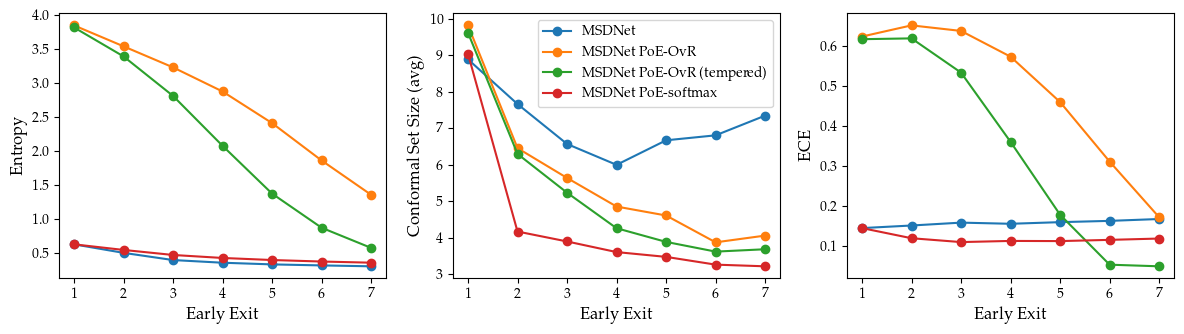

In [11]:
# FONT_SIZE = 12
# plt.rcParams.update({'font.size': FONT_SIZE})

NAMES = ['MSDNet', 'MSDNet PoE-OvR', 'MSDNet PoE-OvR (tempered)', 'MSDNet PoE-softmax']
fig, ax = plt.subplots(1, 3, figsize=(12, 3.5))
for _entropy, label in zip([entropy_baseline, entropy_poe_ovr_break_ties_generalized, entropy_poe_ovr_break_ties_generalized_tempered, entropy_poe], NAMES):
    ax[0].plot(list(range(1, L + 1)), _entropy.mean(axis=1), marker='o', label=label)
ax[0].set_xlabel('Early Exit')
ax[0].set_ylabel('Entropy')

for _probs, label in zip([probs, probs_poe_ovr_break_ties_generalized, probs_poe_ovr_break_ties_generalized_tempered, probs_poe], NAMES):
    ece = []
    for l in range(L):
        ece.append(ECE(bins=15).measure(_probs[l, :, :].numpy(), targets.numpy()))
    ax[2].plot(list(range(1, L + 1)), ece, marker='o', label=label)
ax[2].set_xlabel('Early Exit')
ax[2].set_ylabel('ECE')


for _sizes, label in zip([sizes_conf_sets, sizes_conf_sets_poe_ovr_break_ties_generalized, sizes_conf_sets_poe_ovr_break_ties_generalized_tempered, sizes_conf_sets_poe], NAMES):
    ax[1].plot(list(range(1, L + 1)), _sizes, marker='o', label=label)
ax[1].set_xlabel('Early Exit')
ax[1].set_ylabel('Conformal Set Size (avg)')
ax[1].legend()

plt.tight_layout()
plt.savefig(f'figures/figure_4_raps.pdf', dpi=1200)
plt.show()

# Figure Categorical likelihoods

In [2]:
sns.set_theme()

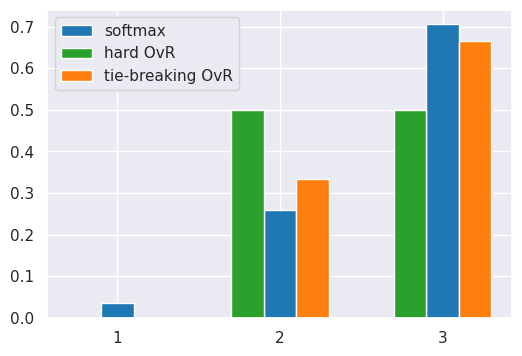

In [3]:
a = torch.tensor([-1., 1., 2.])
b = torch.softmax(a, dim=0).numpy()
c = (torch.sigmoid(a).round() / 2).numpy()
d = torch.tensor([0., 1/3, 2/3])
x = np.arange(1, 4, 1)

fig, ax = plt.subplots(figsize=(6, 4))
plt.bar(x, b, width=0.2, color='tab:blue', align='center', label='softmax')
plt.bar(x-0.2, c, width=0.2, color='tab:green', align='center', label='hard OvR')
plt.bar(x+0.2, d, width=0.2, color='tab:orange', align='center', label='tie-breaking OvR')
plt.xticks(x, [1, 2, 3])
plt.legend()
plt.savefig(f'figures/figure_likelihoods.pdf', dpi=1200)
plt.show()

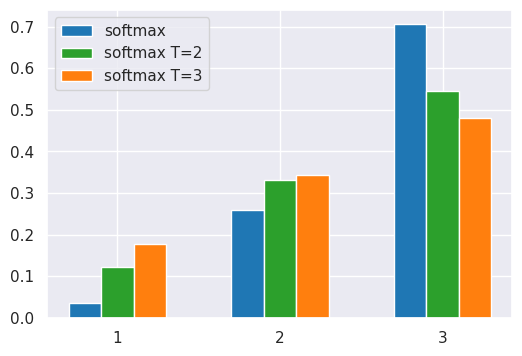

In [5]:
a = torch.tensor([-1., 1., 2.])
b = torch.softmax(a, dim=0).numpy()
c = torch.softmax(a / 2, dim=0).numpy()
d = torch.softmax(a / 3, dim=0).numpy()
x = np.arange(1, 4, 1)

fig, ax = plt.subplots(figsize=(6, 4))
plt.bar(x-0.2, b, width=0.2, color='tab:blue', align='center', label='softmax')
plt.bar(x, c, width=0.2, color='tab:green', align='center', label='softmax T=2')
plt.bar(x+0.2, d, width=0.2, color='tab:orange', align='center', label='softmax T=3')
plt.xticks(x, [1, 2, 3])
plt.legend()
plt.savefig(f'figures/figure_likelihoods.pdf', dpi=1200)
plt.show()